## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
import warnings
import os
import contextlib

## Загрузка данных

In [2]:
df_raw=pd.read_csv(r"C:\Users\Stepan\Desktop\ВУЗ\Клиент-серверные\папка датафреймов\df_after_work_with_cat.csv")
df_raw=df_raw.drop('Unnamed: 0', axis=1)
df_raw

,metro_name,time_to_metro,num_rooms,total_area,year_house,kitchen_area,repair,price,floors,num_floor,address,date,coord_width,coord_len,link,distance_to_Kremlin,district,metro_line,metro_distance
0,Ясенево,8.0,0.0,26.0,1700.0,0.0,евро,3174900.0,16.0,16.0,"Москва, ул. Паустовского, 8к3",10,55.599967,37.536365,https://www.avito.ru/moskva/kvartiry/kvartira-...,17.62,Ясенево,Калужско-Рижская,12
1,Улица академика Янгеля,31.0,0.0,10.0,1973.0,0.0,требует ремонта,2500000.0,12.0,1.0,"Москва, Медынская ул., 4/1",10,55.592490,37.645717,https://www.avito.ru/moskva/kvartiry/kvartira-...,17.76,Бирюлёво Западное,Серпуховско-Тимирязевская,9
2,Братиславская,25.5,0.0,14.5,1700.0,0.0,косметический,5700000.0,26.0,9.0,"ул. Люблинская, вл. 72, корп. 11",10,55.665770,37.734130,https://www.avito.ru/moskva/kvartiry/kvartira-...,11.96,Люблино,Люблинско-Дмитровская,7
3,Панфиловская,8.0,0.0,8.0,1960.0,0.0,дизайнерский,4900000.0,1.0,1.0,"Москва, ул. Маршала Конева, 2",10,55.799952,37.491889,https://www.avito.ru/moskva/kvartiry/kvartira-...,9.59,Щукино,БКЛ,6
4,Рассказовка,31.0,0.0,20.0,2012.0,0.0,косметический,3290000.0,3.0,2.0,"Москва, Новомосковский административный округ,...",10,55.647214,37.327623,https://www.avito.ru/moskva/kvartiry/kvartira-...,21.62,NaN,Солнцевская,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9349,Спартак,5.0,5.0,137.0,2020.0,18.0,требует ремонта,45000000.0,22.0,16.0,"Москва, Волоколамское ш., 71к5",38,55.815999,37.429959,https://www.avito.ru/moskva/kvartiry/5-k._kvar...,13.82,Покровское-Стрешнево,Таганско-Краснопресненская,8
9350,Кропоткинская,8.0,5.0,230.0,1700.0,25.0,евро,210000000.0,7.0,4.0,"Москва, 2-й Обыденский пер., 3с1",33,55.741546,37.604421,https://www.avito.ru/moskva/kvartiry/5-k._kvar...,1.42,Хамовники,Сокольническая,3
9351,Чкаловская,13.0,5.0,342.0,2023.0,35.0,требует ремонта,318034178.0,9.0,9.0,"Москва, Серебрянический пер., 8",25,55.750019,37.647457,https://www.avito.ru/moskva/kvartiry/5-k._kvar...,1.80,Таганский,Люблинско-Дмитровская,1
9352,Минская,25.5,6.0,583.0,1700.0,58.0,евро,295000000.0,22.0,19.0,"Москва, Минская ул., 1Гк2",33,55.712122,37.499067,https://www.avito.ru/moskva/kvartiry/6-k._kvar...,8.68,Раменки,Солнцевская,2


## Работа с категориальными признаками

Определим список категориальных признаков

In [3]:
cat_col=['district','metro_line', 'repair', 'num_rooms']

Построим графики зависмости  средней цены в категории от категориальных признаков

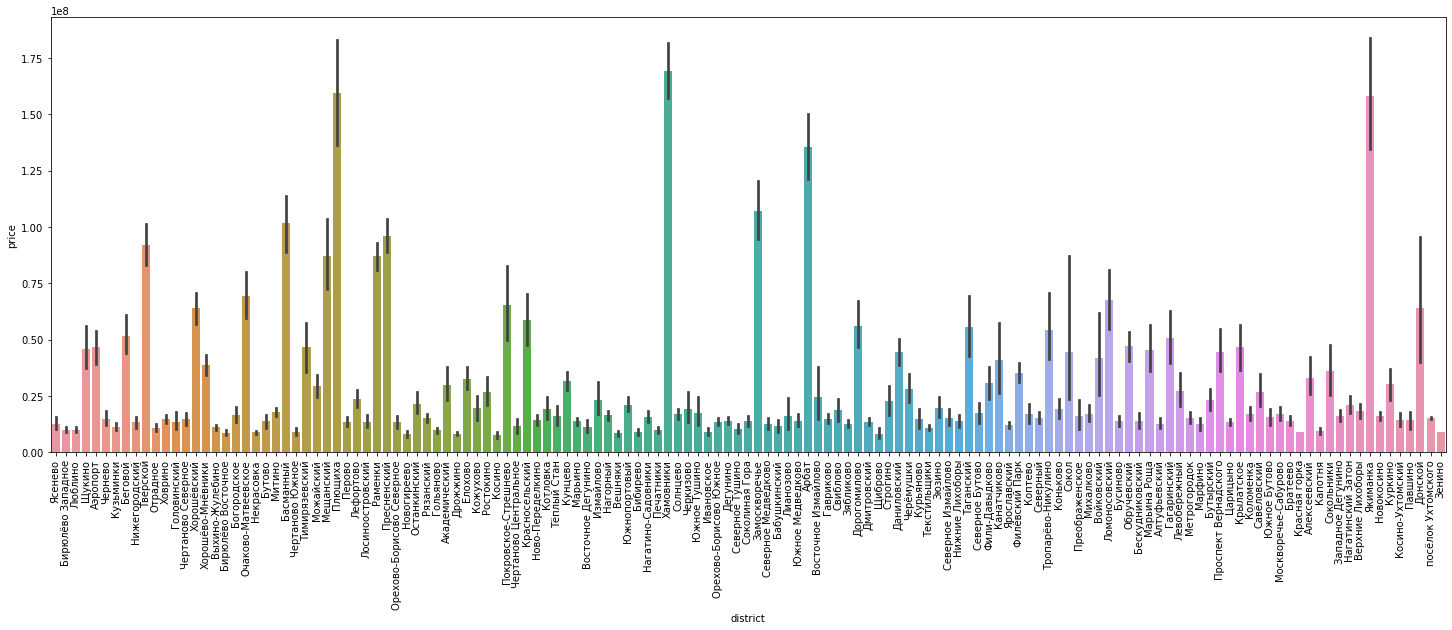

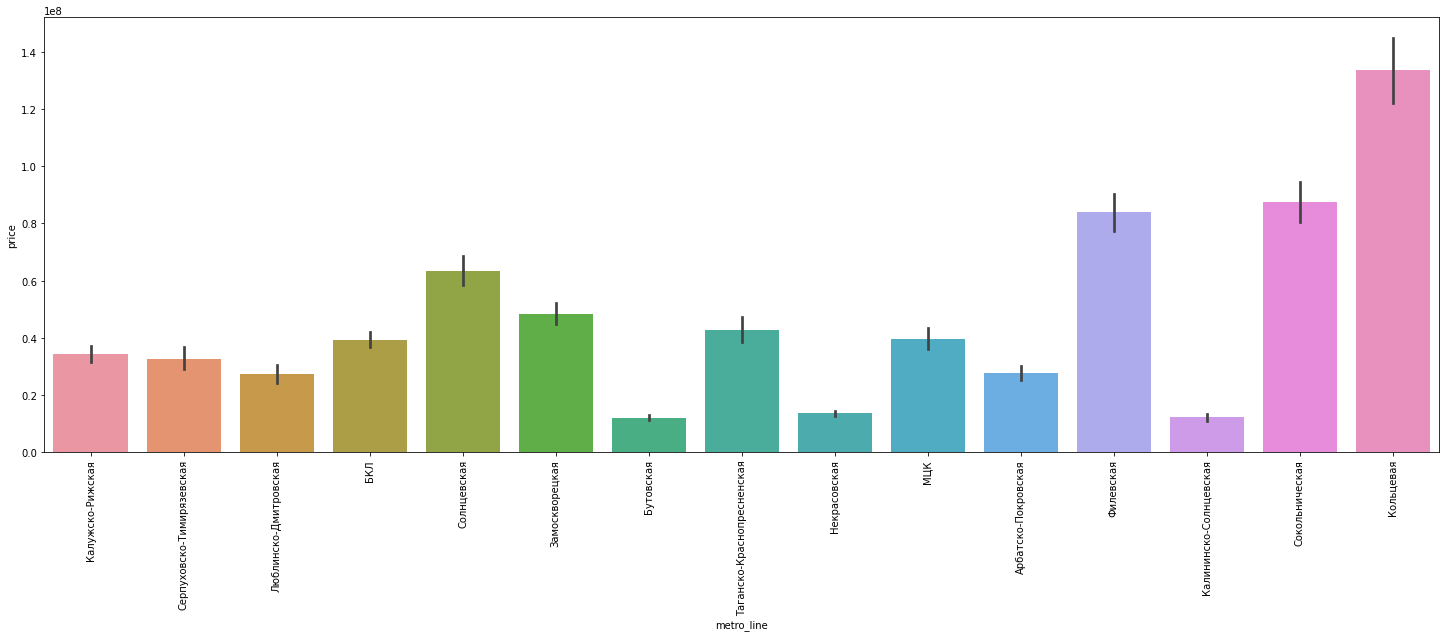

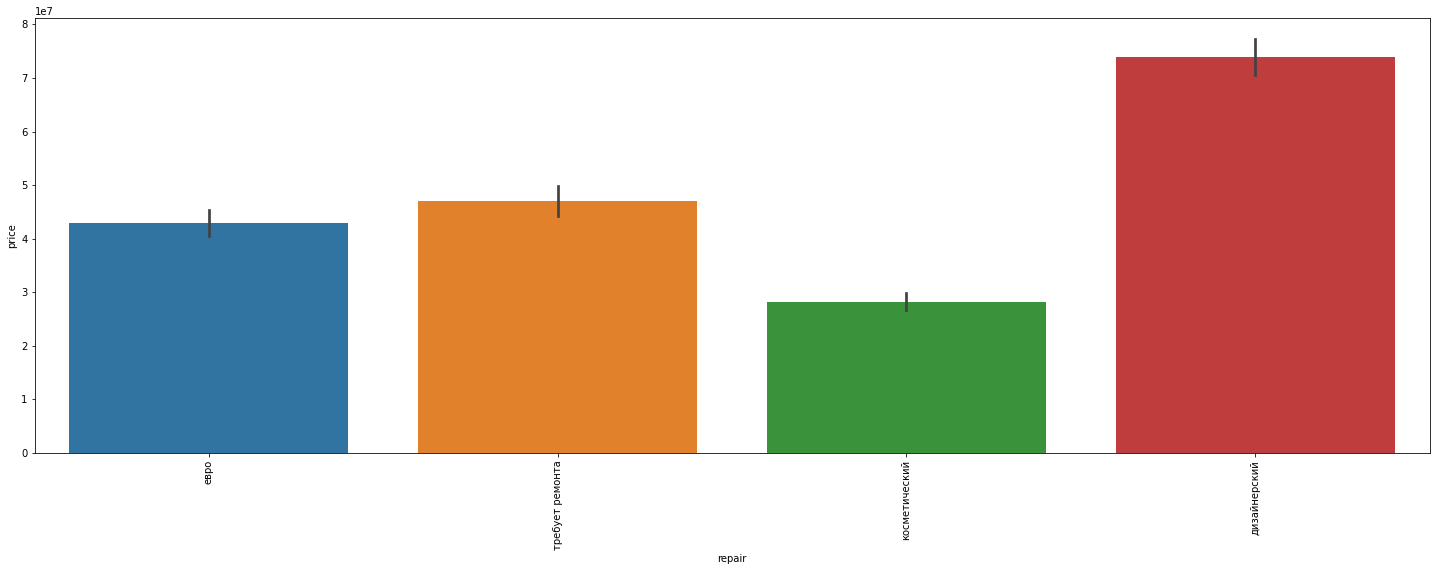

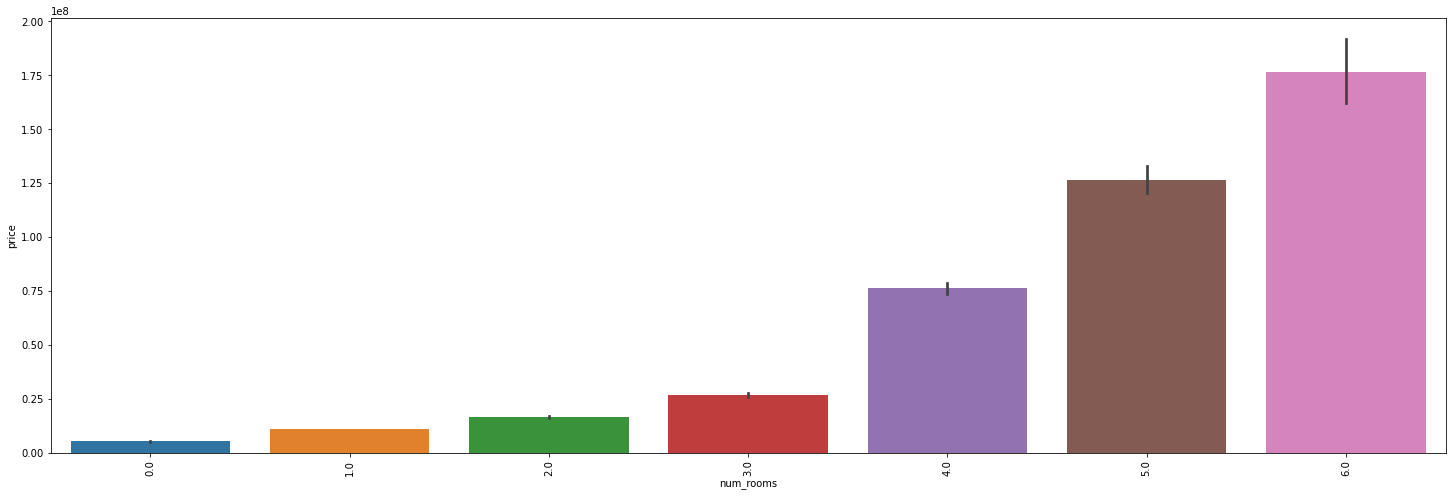

In [4]:
for i in cat_col:
    fig, axes = plt.subplots(1, figsize=(25, 8))
    for item in axes.get_xticklabels():
        item.set_rotation('vertical')
    
    sns.barplot(x=i, y='price', data=df_raw)
    plt.show()

## Кодирование признаков

Будем использовать для кодировки mean target encoding. Реализую его самостоятельно. Буду пользоваться сглаживанием. То есть кодировать будем как $(mean(target)* nrows+globalmean* \alpha)/(nrows+\alpha)$. $\alpha$ для каждого признака будем брать свой.

In [5]:

def target_encoding(feature, alpha, data, globalmean, target):
    df=data.copy()
    for i in data[feature].unique():
        mean_cat=data.loc[data[feature]==i, target].mean()
        n_rows=len(data.loc[data[feature]==i, feature])
        df.loc[data[feature]==i, feature]=(mean_cat*n_rows+globalmean*alpha)/(n_rows+alpha)
    return df
        

Протестируем на синтетическом датасете

In [6]:
df_s=pd.DataFrame(columns=['x','y'])
df_s['x']=[1,0,1,0, 1, 0]
df_s['y']=[1,2,3,4,5,6]
target_encoding('x', alpha=2,data=df_s, globalmean=df_s['y'].mean(), target='y')

,x,y
0,3.2,1
1,3.8,2
2,3.2,3
3,3.8,4
4,3.2,5
5,3.8,6


Тест прошел успешно

In [7]:
globalmean=df_raw['price'].mean()
dict_alpha={'num_rooms':80,'metro_line':30, 'repair':100,'district':5}
df_mte=df_raw.copy()
for i in cat_col:
    df_mte[i]=target_encoding(i, dict_alpha[i], df_raw, globalmean,'price')[i]
    df_mte[i]=df_mte[i].astype('float')
df_mte.sample(5)

,metro_name,time_to_metro,num_rooms,total_area,year_house,kitchen_area,repair,price,floors,num_floor,address,date,coord_width,coord_len,link,distance_to_Kremlin,district,metro_line,metro_distance
8345,Ростокино,13.0,1.189870e+08,186.0,2010.0,25.0,7.240566e+07,53000000.0,58.0,17.0,"Москва, пр-т Мира, 188Бк1",11,55.834472,37.658059,https://www.avito.ru/moskva/kvartiry/5-k._kvar...,9.55,2.858720e+07,3.996936e+07,4
2801,Ленинский проспект,5.0,1.785737e+07,21.0,1700.0,8.0,2.880093e+07,13500000.0,13.0,8.0,"Москва, пр-т 60-летия Октября, 5к2",14,55.704600,37.581191,https://www.avito.ru/moskva/kvartiry/2-k._kvar...,5.72,5.027848e+07,3.476513e+07,4
8172,Шелепиха,8.0,7.533205e+07,100.0,1700.0,10.0,4.699657e+07,39500000.0,51.0,17.0,"Москва, Шмитовский пр., 39к8",30,55.751665,37.526295,https://www.avito.ru/moskva/kvartiry/4-k._kvar...,5.79,9.563419e+07,3.996936e+07,4
7258,Новаторская,18.0,7.533205e+07,130.0,2010.0,18.0,2.880093e+07,48000000.0,48.0,30.0,"Москва, Ленинский пр-т, 111к1",18,55.661333,37.509352,https://www.avito.ru/moskva/kvartiry/4-k._kvar...,12.14,4.704322e+07,3.951886e+07,6
5288,Аэропорт,13.0,2.784192e+07,51.0,2020.0,6.0,4.699657e+07,51000000.0,41.0,2.0,"Москва, Ленинградский пр-т, 37/6",11,55.794190,37.542200,https://www.avito.ru/moskva/kvartiry/3-k._kvar...,6.75,6.338751e+07,4.825756e+07,4


Посмотрим на коррреляцию наших признаков с нашим целевым признаком после mte кодировки

In [8]:
df_mte.drop(['coord_width', 'coord_len', 'date'], axis=1).corr()['price']

time_to_metro         -0.181618
num_rooms              0.691003
total_area             0.847923
year_house            -0.202549
kitchen_area           0.504896
repair                 0.253822
price                  1.000000
floors                 0.046301
num_floor              0.124653
distance_to_Kremlin   -0.487771
district               0.656340
metro_line             0.416257
metro_distance        -0.402042
Name: price, dtype: float64

Довольно хорошие показатели

Также создадим датасет с Label encoding и посмотрим, что лучше

In [9]:
df_le=df_raw.copy()
for i in cat_col:
    le=LabelEncoder()
    df_le[i]=le.fit_transform(df_le[i])
df_le.sample(5)

,metro_name,time_to_metro,num_rooms,total_area,year_house,kitchen_area,repair,price,floors,num_floor,address,date,coord_width,coord_len,link,distance_to_Kremlin,district,metro_line,metro_distance
9029,Арбатская,5.0,5,150.0,1912.0,23.0,1,75000000.0,7.0,4.0,"Москва, Никитский б-р, 5",31,55.753433,37.600109,https://www.avito.ru/moskva/kvartiry/5-k._kvar...,1.19,3,14,1
1094,Медведково,31.0,0,7.5,2021.0,0.0,2,3450000.0,17.0,2.0,"Московская область, городской округ Мытищи, по...",24,55.901702,37.642321,https://www.avito.ru/moskva/kvartiry/kvartira-...,16.77,139,5,10
8646,Смоленская,13.0,5,133.0,1905.0,22.0,3,60000000.0,5.0,3.0,"Москва, Трубниковский пер., 24с1",18,55.754375,37.586913,https://www.avito.ru/moskva/kvartiry/5-k._kvar...,2.02,3,14,2
3168,Давыдково,31.0,2,45.0,1700.0,5.5,2,10500000.0,5.0,2.0,"Москва, Витебская ул., 6",16,55.713792,37.408211,https://www.avito.ru/moskva/kvartiry/2-k._kvar...,13.83,70,1,6
1422,Братиславская,8.0,1,38.0,1998.0,8.0,1,9850000.0,17.0,2.0,"Москва, Братиславская ул., 19к2",16,55.658510,37.762074,https://www.avito.ru/moskva/kvartiry/1-k._kvar...,13.69,65,7,7


## Выбор кодировки

Создадим матрицу признаков и вектор целевой переменной, удалив все ненужные признаки.

In [10]:
X_le, y_le=df_le.drop(['metro_name','price','address','coord_width', 'coord_len', 'link'], axis=1), df_le['price']
X_mte, y_mte=df_mte.drop(['metro_name','price','address','coord_width', 'coord_len', 'link'], axis=1), df_mte['price']

Проверим какая кодировка лучше, используя LGBMRegressor. Будем использовать GridsearchCV для подбора лучших гиперпараметров. После того как "потюним" модель, проверим общую ошибку на 5 фолдах в зависимости от кодировки. Выберем кодировку с меньшей ошибкой

In [11]:
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    lgbm_le=LGBMRegressor(verbose=-1, random_state=42)
    param_grid={'learning_rate':[0.01,0.1, 0.2], 'lambda_l1':[1,15], 'bagging_fraction':[0.5,1],
                    'feature_fraction':[0.5,1], 'n_estimators':[300,1000]}
    gd_le=GridSearchCV(lgbm_le, param_grid, cv=5, return_train_score=False, scoring='neg_mean_absolute_percentage_error',verbose=-1 )
    gd_le.fit(X_le, y_le)


In [12]:
print(f'Лучшие параметры для le кодировки: {gd_le.best_params_}')
print(f'Наименьшая ошибка (MAPE) для le кодировки: {gd_le.best_score_}')


Лучшие параметры для le кодировки: {'bagging_fraction': 0.5, 'feature_fraction': 1, 'lambda_l1': 15, 'learning_rate': 0.1, 'n_estimators': 1000}
Наименьшая ошибка (MAPE) для le кодировки: -0.2499147232768842


In [13]:
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    lgbm_mte=LGBMRegressor(verbose=-1, random_state=42)
    gd_mte=GridSearchCV(lgbm_mte, param_grid, cv=5, return_train_score=False, scoring='neg_mean_absolute_percentage_error',verbose=-1 )
    gd_mte.fit(X_mte, y_mte)


In [14]:
print(f'Лучшие параметры для mte кодировки: {gd_mte.best_params_}')
print(f'Наименьшая ошибка (MAPE) для mte кодировки: {gd_mte.best_score_}')


Лучшие параметры для mte кодировки: {'bagging_fraction': 0.5, 'feature_fraction': 1, 'lambda_l1': 1, 'learning_rate': 0.1, 'n_estimators': 1000}
Наименьшая ошибка (MAPE) для mte кодировки: -0.24320891231481928


Проверим, какая кодировка лучше, используя кроссвалидацию

In [18]:
skf=StratifiedKFold(5, shuffle=True, random_state=100 )
errors_mte=[]
errors_le=[]
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for tr_ind, val_ind in skf.split(X_le, y_le):
            lgbm_mte=LGBMRegressor(**gd_mte.best_params_)
            lgbm_le=LGBMRegressor(**gd_le.best_params_)
            lgbm_mte.fit(X_mte.loc[tr_ind, :], y_mte.loc[tr_ind])
            lgbm_le.fit(X_le.loc[tr_ind, :], y_le.loc[tr_ind])
            errors_mte.append(mape(lgbm_mte.predict(X_mte.loc[val_ind,:]), y_mte.loc[val_ind]))
            errors_le.append(mape(lgbm_le.predict(X_le.loc[val_ind,:]), y_le.loc[val_ind]))


In [19]:
print(f'MAPE для mte кодирования: {np.mean(errors_mte)}')
print(f'MAPE для le кодирования: {np.mean(errors_le)}')

MAPE для mte кодирования: 0.17937576937780825
MAPE для le кодирования: 0.1803161695588708


mte лучше, ее и оставим

## Сохранение данных

In [20]:
df_mte.to_csv(r"C:\Users\Stepan\Desktop\ВУЗ\Клиент-серверные\папка датафреймов\df_after_encoding.csv")